# Access watershed routing information

Ming Han and colleagues have recently published a [pan-Canadian river routing information geospatial database](https://zenodo.org/record/3667677). It describes river channels, lakes and reservoirs, watershed slopes and river slopes, embankments, mean elevation, etc. This database is hosted on the PAVICS geoserver and a few utilities have been created to access it. This information can then be used to create Raven configuration files for sub-basins routing in distributed model configurations.

This notebook demonstrates how to build a table of watershed properties from version 1 of this geospatial database. Version 2 should become available in April or May and this will be updated, so consider this notebook as a draft.

In [2]:
import geopandas as gpd

from ravenpy.utilities import geoserver

## Get routing information for a given location

Here we're fetching watershed information for the subbasin including [Amadjuak Lake](https://en.wikipedia.org/wiki/Amadjuak_Lake), located on Baffin Island's Great Plain of the Koukdjuak (Nunavut), using `geoserver.get_hydro_routing_location_wfs()`.

/home/tjs/mambaforge/envs/ravenpy-env/lib/python3.10/site-packages/owslib/feature/__init__.py:351: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elif filter:


,geometry,area,SubId,DowSubId,Rivlen,RivSlope,BasinSlope,BkfWidth,BkfDepth,IsLake,...,LakeArea,Laketype,IsObs,MeanElev,FloodP_n,Q_Mean,Ch_n,INSIDE_X,INSIDE_Y,STATION_NU
0,"MULTIPOLYGON (((-72.04580 65.22920, -72.04580 ...",9.110308e+09,29881,30001,132876,0.000069,0.012235,46.6959,1.14224,1,...,2994.94,1,-9999.99,144.388,0.048342,49.4539,0.008963,-71.318408,64.787276,


<AxesSubplot: >

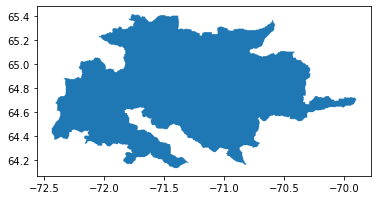

In [3]:
amadjuak = (-71.225, 65.05)

feature = geoserver.get_hydro_routing_location_wfs(
    coordinates=amadjuak * 2, lakes="1km", level=7
)

feat = gpd.GeoDataFrame.from_features(feature)
display(feat)
feat.plot(aspect="equal")

## Fetching routing information for upstream watersheds

With the subbasin ID (`SubId`) for the feature, we can now find all upstream watersheds using `geoserver.hydro_routing_upstream_ids()`.

This function requires information about up-down relationships between watersheds. We can get this info using `geoserver.get_hydro_routing_attributes_wfs()`. This function returns a URL to a JSON-encoded subset, and GeoPandas uses some magic to load it into a GeoDataFrame. Getting this info takes a while...

In [4]:
subbasin_id = feat["SubId"][0]
gdf = geoserver.hydro_routing_upstream(subbasin_id, lakes="1km", level=7)
gdf

,id,area,SubId,DowSubId,Rivlen,RivSlope,BasinSlope,BkfWidth,BkfDepth,IsLake,...,Laketype,IsObs,MeanElev,FloodP_n,Q_Mean,Ch_n,INSIDE_X,INSIDE_Y,STATION_NU,geometry
0,routing_1kmLakes_07.16390,1.561850e+09,29878,29957,43618.900,0.001001,0.011948,28.2839,0.783040,-9999.99,...,-9999.99,-9999.99,270.853,0.049727,15.82250,0.033922,-69.639583,64.593750,,"MULTIPOLYGON (((-69.88330 64.42920, -69.88330 ..."
1,routing_1kmLakes_07.16391,2.117180e+09,29879,29957,633.787,0.000100,0.026252,22.4685,0.649329,-9999.99,...,-9999.99,-9999.99,381.230,0.049898,10.83760,0.146774,-69.095873,64.523379,,"MULTIPOLYGON (((-69.87920 64.35830, -69.88750 ..."
2,routing_1kmLakes_07.16393,9.110308e+09,29881,30001,132876.000,0.000069,0.012235,46.6959,1.142240,1.00,...,1.00,-9999.99,144.388,0.048342,49.45390,0.008963,-71.318408,64.787276,,"MULTIPOLYGON (((-72.04580 65.22920, -72.04580 ..."
3,routing_1kmLakes_07.16450,6.153782e+06,29938,29955,833.501,0.001200,0.005017,12.7818,0.422461,1.00,...,1.00,-9999.99,166.853,0.050000,3.15153,0.053123,-70.526103,65.240196,,"MULTIPOLYGON (((-70.50420 65.26670, -70.50420 ..."
4,routing_1kmLakes_07.16451,7.908222e+06,29939,30004,1328.880,0.002258,0.011083,11.7369,0.395272,1.00,...,1.00,-9999.99,350.943,0.050000,2.65731,0.039359,-69.783501,65.122103,,"MULTIPOLYGON (((-69.76250 65.10420, -69.78750 ..."
5,routing_1kmLakes_07.16452,8.290501e+06,29940,30005,988.695,0.002023,0.006781,11.7369,0.395272,1.00,...,1.00,-9999.99,292.286,0.050000,2.65731,0.058264,-69.976854,65.061790,,"MULTIPOLYGON (((-69.95830 65.06250, -69.95830 ..."
6,routing_1kmLakes_07.16453,3.656614e+08,29941,30006,2696.100,0.000742,0.009481,17.4253,0.537979,1.00,...,1.00,-9999.99,231.015,0.051667,5.85728,0.025679,-70.191934,65.097385,,"MULTIPOLYGON (((-70.21670 64.90420, -70.21670 ..."
7,routing_1kmLakes_07.16454,4.038877e+06,29942,29956,929.087,0.000100,0.000925,22.3404,0.653033,1.00,...,1.00,-9999.99,151.500,0.050000,9.62755,0.031088,-70.270833,64.859375,,"MULTIPOLYGON (((-70.25830 64.86250, -70.25830 ..."
8,routing_1kmLakes_07.16455,5.105304e+07,29943,30008,3474.390,0.002878,0.012721,14.1089,0.456297,1.00,...,1.00,-9999.99,352.823,0.050000,3.83989,0.047209,-69.350454,64.802016,,"MULTIPOLYGON (((-69.35420 64.73750, -69.37920 ..."
9,routing_1kmLakes_07.16456,1.501280e+07,29944,29878,2990.080,0.002341,0.013047,18.3889,0.561046,1.00,...,1.00,-9999.99,258.896,0.061667,6.52299,0.046427,-69.719287,64.767958,,"MULTIPOLYGON (((-69.72080 64.80420, -69.72080 ..."


Number of features: 33


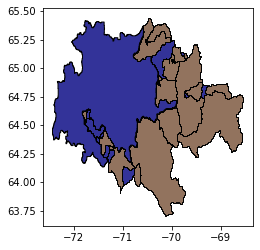

In [5]:
# Plotting all features upstream of the subbasin of interest, including Amadjuak Lake.
# Lakes are in blue and land in brown.
# Note that the contours show basins that include lakes, not the lakes themselves.

gdf.plot(column="IsLake", cmap="terrain_r", edgecolor="black", vmin=-14000)
print(f"Number of features: {len(gdf)}")

## Routing configuration

The routing information stored on Geoserver is from version 1 of the routing database. The RavenPy code was however designed with V2 as a target, which is not yet publicly available. The following code uses a test data sample from V2 to illustrate how the routing information can be used to configure Raven. V2 should become available in Spring 2021.

In [6]:
import datetime as dt

from ravenpy.config.commands import SBGroupPropertyMultiplierCommand
from ravenpy.extractors import RoutingProductShapefileExtractor
from ravenpy.models import GR4JCN, get_average_annual_runoff
from ravenpy.utilities.testdata import get_file

In [7]:
path = get_file("raven-routing-sample/finalcat_hru_info.zip")
config = RoutingProductShapefileExtractor(path).extract(model=GR4JCN)
total_area = sum(hru.area for hru in config["hrus"]) * 1e6

`config` is a dictionary of Raven configuration objects.

In [8]:
config.keys()

dict_keys(['subbasins', 'land_subbasin_ids', 'lake_subbasin_ids', 'reservoirs', 'channel_profiles', 'hrus'])

In [9]:
ts = get_file("raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily_2d.nc")
model = GR4JCN()
model(
    ts=ts,
    params=model.Params(0.529, -3.396, 407.29, 1.072, 16.9, 0.947),
    start_date=dt.datetime(2000, 1, 1),
    end_date=dt.datetime(2002, 1, 1),
    routing="ROUTE_DIFFUSIVE_WAVE",
    avg_annual_runoff=get_average_annual_runoff(ts, total_area),
    land_subbasin_property_multiplier=SBGroupPropertyMultiplierCommand(
        "Land", "MANNINGS_N", 1.0
    ),
    lake_subbasin_property_multiplier=SBGroupPropertyMultiplierCommand(
        "Lakes", "RESERVOIR_CREST_WIDTH", 1.0
    ),
    **config,
)

/home/tjs/git/RavenPy/ravenpy/models/base.py:400: RavenWarning: Gauge:Initialize: both snowfall and rainfall data are provided at a gauge, but :RainSnowFraction method is something other than RAINSNOW_DATA. Snow fraction will be recalculated.
  warn(msg, category=RavenWarning)
/home/tjs/git/RavenPy/ravenpy/models/base.py:400: RavenWarning: PET data supplied at gauge default_1 but will not be used due to choice of forcing generation algorithm
  warn(msg, category=RavenWarning)
/home/tjs/git/RavenPy/ravenpy/models/base.py:400: RavenWarning: CModelInitialize: if a non-standard calendar is used, all observation data must be converted into the same calendar format
  warn(msg, category=RavenWarning)
/home/tjs/git/RavenPy/ravenpy/models/base.py:400: RavenWarning: CModelInitialize: if a non-standard calendar is used, care must be taken with forcing data. All gauge forcing data must use the same calendar convention. Mixed calendars are only supported for NetCDF forcing inputs.
  warn(msg, categ

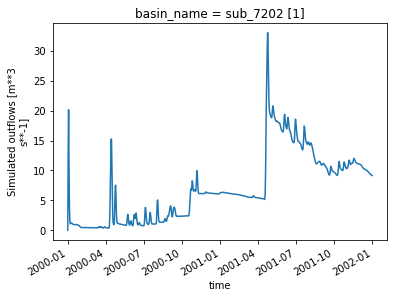

In [10]:
model.q_sim.plot();